# Imports

In [77]:
import os
import logging
import glob
import copy
import os
import json
import gzip
import pickle

from typing import List, Dict, Optional, Union, Callable, Tuple
from collections import namedtuple, Counter, defaultdict
from itertools import product
from statistics import median
from copy import deepcopy

import lxml.etree as ET
import numpy as np
import seaborn as sns
import tqdm
import requests
import pandas as pd

from memoization import cached
from pandas import DataFrame, read_csv, qcut
from sklearn.decomposition import PCA, FactorAnalysis as FA
from scipy.cluster.hierarchy import dendrogram
from sklearn.cluster import AgglomerativeClustering

import matplotlib.pyplot as plt
import plotly.express as px
from IPython.display import HTML, display
from slugify import slugify
plt.style.use('seaborn')
#requests_cache.install_cache('importance-segmentation.cache')

# General setup (constants et al.)

## Setup the lemmas that are interesting to search for

In [78]:

lemmas = []
for text in glob.glob("/home/thibault/dev/corpus-builder/output/*.xml"):
    xml = ET.parse(text)
    lemmas.extend([
        y[:y.find("(")]
        for x in xml.xpath("//w[@ana]/@lemma") 
        for y in x.split("|")
        if y
    ])
lemmas = sorted(list(set(lemmas)))


SERVER = "http://localhost:8888/blacklab-server/latin-corpus-index/hits"
GLOBAL_WINDOW = 10
MIN_FREQ = 10
COOC_MIN_FREQ = 10
COOC_USE_SUM = True
NORMALIZATION: str = "coeff-dice"
IGNORE_WORDS = ("sum1", "que", "habeo", "dico2", "facio", "possum1", "do", "uideo", "uolo3", "iam", "sic",
               "tamen", "tam", "puto", "res", "suus", "hic2")
TEXTS = ["urn:cts:latinLit:phi1294.phi002.perseus-lat2", "urn:cts:latinLit:phi1103.phi001.lascivaroma-lat1"]

BAD_CACHE = defaultdict(Counter) # {textlist: {word: count}}
POS = [
    "ADJadv.mul", "ADJadv.ord", "ADJcar", "ADJdis", "ADJmul", "ADJord", 
    #"ADJqua", 
    "ADV", "ADVint", "ADVint", "ADVneg", "ADVrel", 
    "CONcoo", "CONsub", "INJ",
    "NOMcom", "NOMpro", 
    "OUT", "PRE", "PROdem", 
    "PROind", "PROint", "PROper", "PROpos", "PROpos", "PROref", "PROrel", "PUNC", 
    "VER", "VERaux", "FOR"
]
IGNORE_FEATURE_POS = [
    "ADJadv.mul", "ADJadv.ord", "ADJcar", "ADJdis", "ADJmul", "ADJord", 
    #"ADJqua", 
    #"ADV", 
    "ADVint", "ADVint", "ADVneg", "ADVrel", 
    "CON", "CONcoo", "CONsub", "INJ", 
    #"NOMcom", "NOMpro",
    "OUT", "PRE", "PROdem", 
    "PROind", "PROint", 
    #"PROper", "PROpos", 
    "PROpos", "PROref", "PROrel", "PUNC", 
    #"VER", 
    "VERaux", "FOR"
]
POS_FOR_CLASSES = [
    "ADJqua", "ADV", "NOMcom", "NOMpro", "VER"
]
PLOT = False
PLOTLY = True
PYPLOT = False
SCORER = "dice"
DATATION = read_csv("../../data/raw/datation.tsv", dialect="excel-tab").fillna("")
DATATION = DATATION[DATATION["Ignore"] == ""]

### Download POS dictionary

In [79]:
req = requests.get("https://github.com/lascivaroma/forcellini-lemmas/raw/master/dictionary.tsv")
with open("dictionary.tsv", "w") as f:
    f.write(req.text)

LEMMA_POS_DICT = read_csv("dictionary.tsv", dialect="excel-tab", index_col="lemma").fillna("")
IGNORE_WORDS_AS_CLASS = LEMMA_POS_DICT[~LEMMA_POS_DICT.POS.isin(POS_FOR_CLASSES)].index.to_list()

### Retrieve splits for texts

In [80]:
#TEXT_SPLITS = {
#    "urn:cts:latinLit:phi1294.phi002.perseus-lat2": 2,  # Stop at the second element of citation
#    "urn:cts:latinLit:phi1103.phi001.lascivaroma-lat1": 1
#}
TEXT_SPLITS = {
    row["URN"]: row["Citation level"]
    for _, row in DATATION.iterrows()
}

### Search texts that have specific citation scheme

In [81]:
SMALL_PASSAGES = DATATION[DATATION["Name of citation level"].str.contains("poem|comment|entry|scholia|letter|speech")]["URN"].to_list()
ALL_TEXTS = sorted(list(TEXT_SPLITS.keys()))
MARTIAL_PRIAPEA = [
    "urn:cts:latinLit:phi1294.phi002.perseus-lat2",
    "urn:cts:latinLit:phi1103.*"
]
print(len(SMALL_PASSAGES))

127


### Get research lemma

In [82]:
EXCLUDED = "ad2 ipse munus uolo3 facio rumpo uxor ille nos meus uir res porto janua Uenus".split() + list(IGNORE_WORDS)
WORDS = sorted([
    "mentula", "cunnus", "lasciuus", "paedico2", 
    "futuo", "culus", "irrumo", "fello", "fellator",
    "castus", "improbus", "probus",
    "effeminatus"
    #"caco" #, "medium", 
])

EXTEND = False
if EXTEND:
    WORDS.extend(sorted(list(set([
        l 
        for l in lemmas
        if l not in EXCLUDED
    ]))))

# Functions

## Object types

In [83]:
# Search
Token = namedtuple("Token", ["text", "lemma", "pos", "ref"])
Hit = namedtuple("Hit", ["left", "right", "text_id", "ref", "lemma"])

SearchResults = namedtuple("SearchResults", ["coocs", "hit_counts", "pos_dict"])
SecondaryCoocs = namedtuple("SecondaryCoocs", ["pivots", "major_coocs", "ignored_features", "distances"])
SecondaryCoocsLight = namedtuple("SecondaryCoocs", ["pivots", "major_coocs", "ignored_features"])

CoocAnalysisResults = namedtuple(
    "CoocAnalysisResults",
    ["df_coocs", "df_scores", "pivots", "coocs_major", "coocs_dropped", "freqs"]
)
# Summary
CleanDirty = namedtuple("CleanDirty", ["clean", "dirty"])
# PCA
ComputedPCAs = namedtuple("ComputedPCAs", ["models", "transformed"])
# Alignment
AlignedDFs = namedtuple("AlignedDFs", ["dfs", "ignored", "dropped_features"])
NotFound = namedtuple("NotFound", ["classes", "features"])

## Scoring of relations

In [84]:
def compute_scores(df, score_type="dice"):
    #i = df.index.to_list()
    #j = df.columns.to_list()
    
    Oij = np.array(df)
    Ri = np.array(df.sum(axis=1)) # Classes (Pivots)
    Cj = np.array(df.sum(axis=0)) # Feature (Coocs)
    
    
    if score_type == "dice":
        out = 2 * Oij / np.add.outer(Ri, Cj) # 2*O_11 / (O_11 + O_12 + O_11 + O_21)
    elif score_type == "jaccard":
        out = Oij / (np.add.outer(Ri, Cj) - Oij) # O11 / (O_11 + O_12 + O_11 + O_21) - O11
    else:
        raise "Unknown score " + score_type
    return DataFrame(out, index=df.index, columns=df.columns)

## Window / processing of raw results

In [85]:
def filter_ref(words, main_word, text=None, splits=TEXT_SPLITS):
    main = main_word.attrib["n"].split(".")[:TEXT_SPLITS[text]]
    return [
        word 
        for word in words
        if word.attrib["n"].split(".")[:TEXT_SPLITS[text]] == main
    ]


def get_window(index, words, window, serious_window=False, text=None, filter_pos=None, 
               splits: Dict[str, int] = TEXT_SPLITS):
    start = max(index-window, 0)
    end = min(index+window+1, len(words)-1)
    out = words[start:index] + words[index+1:end]
    if filter_pos:
        out = [tok for tok in out if tok.attrib["pos"] not in filter_pos]
    if serious_window is False:
        return out
    return filter_ref(out, main_word=words[index], text=text, splits=splits)

## Expand files path

In [86]:
def get_expanded_directories(texts):
    return [
        subtext
        for text in texts
        for subtext in (
            [f"/home/thibault/dev/latin-lemmatized-texts/lemmatized/xml/{text}.xml"] if "*" not in text else glob.glob(f"/home/thibault/dev/latin-lemmatized-texts/lemmatized/xml/{text}.xml")
        )
    ]

def get_text_id(text):
    return text.split("/")[-1].replace(".xml", "")

## General Frequency building function

In [87]:
def get_corpus_full_frequencies(
    texts: List[str],
    ignore_pos: Optional[List[str]] = None,
    filter_pos: Optional[List[str]] = None
):
    """ Retrieve all frequencies from a given corpus
    
    :param texts: Lists of text identifiers that are looked into
    :param ignore_pos: POS to ignore in counting cooccurences (like punct)
    :param filter_pos: POS to count in the window but not as a feature for the cooccurences
    
    """
    ignore_pos = ignore_pos or []
    filter_pos = filter_pos or []
    GenFreq = Counter()
    FreqPerCorpus = defaultdict(Counter)
    
    for text in get_expanded_directories(texts):
        text_id = get_text_id(text)
        if not os.path.exists(text):
            logging.warning(f"{text_id} does not exist")
            continue
        xml = ET.parse(text)
        current_text = Counter([
            w.attrib["lemma"]
            for w in xml.xpath(
                    f"//tei:w[not(contains(\"{'|'.join(ignore_pos)}\", @pos))]",
                    namespaces={"tei": "http://www.tei-c.org/ns/1.0"}
                )
            if not filter_pos or (filter_pos and w.attrib["pos"] not in filter_pos)
        ])
        GenFreq.update(current_text)
        FreqPerCorpus[text_id].update(current_text)
        
    FreqLemmaPerCorpus = defaultdict(Counter)
    for corpus in FreqPerCorpus:
        for lemma, occs in FreqPerCorpus[corpus].items():
            FreqLemmaPerCorpus[lemma][corpus] += occs
            
    return GenFreq, FreqPerCorpus, FreqLemmaPerCorpus

## Word searching

In [88]:
def search_words(
    texts: List[str],
    lemma: List[str],
    window: int,
    ignore_pos: Optional[List[str]] = None,
    filter_pos: Optional[List[str]] = None,
    serious_window: bool = False,
    splits: Dict[str, int] = TEXT_SPLITS,
    use_lemma_distrib: Optional[Dict[str, Counter]] = None
):
    """ Retrieve words and cooccurrents
    
    :param texts: Lists of text identifiers that are looked into
    :param ignore_pos: POS to ignore in counting cooccurences (like punct)
    :param filter_pos: POS to count in the window but not as a feature for the cooccurences
    :param lemma: Lemma which are searched
    :param window: Number of words on the left and on the right to keep
    :param serious_window: Keep only cooccurrences in the same document segment.
    
    """
    ignore_pos = ignore_pos or []
    filter_pos = filter_pos or []
    
    coocs = defaultdict(Counter)
    freqs = Counter()
    pos_dict = {}
    
    if use_lemma_distrib:
        pivots_found_in = set()
        for pivot in lemma:
            pivots_found_in = pivots_found_in.union(set(use_lemma_distrib[pivot].keys()))
        logging.warning(f"{len(texts)} texts before")
        texts = list(set(texts).intersection(pivots_found_in))
        logging.warning(f"{len(texts)} texts after")
    
    for text in get_expanded_directories(texts):
        text_id = get_text_id(text)
        if not os.path.exists(text):
            logging.warning(f"{text_id} does not exist")
            continue
        xml = ET.parse(text)
        words = xml.xpath(
            f"//tei:w[not(contains(\"{'|'.join(ignore_pos)}\", @pos))]",
            namespaces={"tei": "http://www.tei-c.org/ns/1.0"}
        )
        for index, word in enumerate(words):
            if word.attrib["lemma"] in lemma:
                if filter_pos and word.attrib["pos"] in filter_pos:
                    continue
                freqs[word.attrib["lemma"]] += 1
                data = get_window(
                    index, 
                    words, 
                    window, 
                    serious_window=serious_window,
                    text=text_id,
                    filter_pos=filter_pos,
                    splits=splits
                )
                pos_dict.update({
                    w.attrib["lemma"]: w.attrib["pos"]
                    for w in data
                })
                coocs[word.attrib["lemma"]].update(Counter([w.attrib["lemma"] for w in data]))   
                
    return SearchResults(coocs, freqs, pos_dict)

## Co-occurencies to DataFrame

In [89]:
def dataframe_from_coocs(
    search_results: SearchResults,
    floor: int,  # Minimal number of hits / query lemma to be taken in the analysis
    cooc_floor: int,  # Minimal number of cooccurrences to be taken into account
    ignore_words: Optional[List[str]] = None  # Words to ignore as feature
) -> DataFrame:
    ignore_words = ignore_words or []
    
    # Warns about data that does not meet a minimal threshold
    for k, v in search_results.coocs.items():
        if len(v) and search_results.hit_counts[k] < floor:
            logging.warning(f"{k} [pivot] because for "
                            f" insuff. freq ({search_results.hit_counts[k]} < {floor} limit)")
            
    df = DataFrame({
        k:v
        for k, v in search_results.coocs.items()
        if len(v) and search_results.hit_counts[k] >= floor
    }).transpose()
    
    # Drop items where the number of cooccurrences is too low
    df.drop([
        col
        for col, val in df.sum().iteritems()
        if val < cooc_floor or col in ignore_words# or col in pivots  # Remove pivots as feature ?
    ], axis=1, inplace=True)
    
    return df

## Combined search with co-occurrents

In [90]:
def get_secondary_coocs(
    search_results: SearchResults,
    results_dataframe: DataFrame,
    pos_for_classes: List[str] = None,
    ignore_words=IGNORE_WORDS,
    scorer: str = "dice",  # See compute_scores()
    scorer_floor: Union[Callable, float] =0.02,
    use_max: bool = True
) -> (Dict[str, Dict[str, int]], Dict[str, int], Dict[str, int]):
    
    # Param defaults to usable values
    pos_for_classes = pos_for_classes or []
    
    # Retrieve distances
    distances = compute_scores(results_dataframe, score_type=scorer)
    dist_max = distances.max(axis=0)
    
    if not isinstance(scorer_floor, float):
        logging.info("Applying function for coefficient filter")
        scorer_floor = scorer_floor(dist_max)
    else:
        logging.info("Applying %s as coefficient filter" % scorer_floor)
        
    # Filter features and classes
    pivots = results_dataframe.index.to_list()
    original_features = results_dataframe.columns.to_list()
    features_but_not_classes = [col for col, val in dist_max.iteritems() if val < scorer_floor]
    major_coocs = [
        feature_lemma
        for feature_lemma in original_features
        if 
            feature_lemma not in pivots and 
            feature_lemma not in features_but_not_classes and 
            search_results.pos_dict[feature_lemma] in pos_for_classes
    ]
    
    return SecondaryCoocs(
        pivots=pivots,
        major_coocs=major_coocs,
        ignored_features=features_but_not_classes,
        distances=distances
    )

## Advanced filter for classes

In [91]:
def refilter_secondary_coocs(
    results_dataframe: DataFrame,
    pivots: List[str],
    pos_for_classes: List[str] = None,
    ignore_words=IGNORE_WORDS,
    scorer: str = "dice",  # See compute_scores()
    scorer_floor: Union[Callable, float] =0.02,
    use_max: bool = True,
    filter_on_distance: bool = False,
    ignore_word_for_classes: List[str] = None
) -> (Dict[str, Dict[str, int]], Dict[str, int], Dict[str, int]):
    
    # Param defaults to usable values
    pos_for_classes = pos_for_classes or []
    ignore_word_for_classes or []

    print(pivots)
    
    # If we ignore words for class, we should ignore them in distances.

    if filter_on_distance:
        results_dataframe = results_dataframe[results_dataframe.columns.difference(
            list(ignore_word_for_classes) + list(ignore_words)
        )]

    # Compute distances
    distances = compute_scores(results_dataframe, score_type=scorer)
    dist_max = distances.max(axis=0)
    
    original_features = results_dataframe.columns.to_list()

    if isinstance(scorer_floor, str) and scorer_floor.startswith("n-largest"):
        nb = int(scorer_floor.split(":")[1])
        classes = []
        for piv in pivots:
            n_largest = distances.loc[piv].nlargest(nb, "all").index.to_list()
            classes.extend(n_largest)
        major_coocs = sorted(list(set(classes).difference(set(pivots))))
        features_but_not_classes = set(original_features).difference(set(major_coocs))
    else:
        if not isinstance(scorer_floor, float):
            logging.info("Applying function for coefficient filter")
            scorer_floor = scorer_floor(dist_max)
        else:
            logging.info("Applying %s as coefficient filter" % scorer_floor)

        features_but_not_classes = [col for col, val in dist_max.iteritems() if val < scorer_floor]
        major_coocs = [
            feature_lemma
            for feature_lemma in original_features
            if 
                feature_lemma not in pivots and 
                feature_lemma not in features_but_not_classes
        ]
    
    return SecondaryCoocs(
        pivots=pivots,
        major_coocs=major_coocs,
        ignored_features=features_but_not_classes,
        distances=distances
    )

## Merge Search Results

In [92]:
def merge_search_results(
    pivots_results: SearchResults,  #["occs", "hit_counts", "pos_dict"]
    major_coocs_results: SearchResults
) -> SearchResults:
    data = []
    for pivot, major in zip(pivots_results, major_coocs_results):
        data.append(copy.deepcopy(pivot))
        data[-1].update(major)
        
    return SearchResults(*data)

## Normalization

In [93]:
def normalize_dataframe(
    dataframe: DataFrame,
    normalization: str,
    freqs: Optional[Counter] = None
) -> DataFrame:
    # Normalisation: quel part des occurences globales des coocurrents 
    #   représente chacune des occurences rencontrées 
        
    if normalization.startswith("ratio"):
        dataframe = dataframe.divide([freqs[col] for col in dataframe.columns])
    if "-log" in normalization:
        dataframe = dataframe.apply(np.log10)
    if normalization == "binarize":
        dataframe = dataframe.fillna(0).apply(lambda x: x != 0)
    if normalization.startswith("coeff-"):
        dataframe = compute_scores(dataframe, score_type=normalization.split("-")[-1])
    
    return dataframe


## Align DF

In [94]:
def align_dataframes_indexes(clean_df, dirty_df):
    # Filter features first
    filtered_clean = clean_df.copy(deep=True)
    filtered_dirty = dirty_df.copy(deep=True)
    
    
    clean_class_not_found = set(filtered_clean.index).difference(set(filtered_dirty.index)) # In Clean but not in dirty
    dirty_class_not_found = set(filtered_dirty.index).difference(set(filtered_clean.index)) # In Dirty but not in clean

    clean_feature_not_found = set(filtered_clean.columns).difference(set(filtered_dirty.columns)) # In Clean but not in dirty
    dirty_feature_not_found = set(filtered_dirty.columns).difference(set(filtered_clean.columns)) # In Dirty but not in clean
    
    filtered_clean = filtered_clean.drop(index=clean_class_not_found)
    filtered_dirty = filtered_dirty.drop(index=dirty_class_not_found)
    
    filtered_clean = filtered_clean.dropna(axis=1, how="all")
    filtered_dirty = filtered_dirty.dropna(axis=1, how="all")
    
    clean_dropped_features = set(clean_df.columns.to_list()).difference(set(filtered_clean.columns.to_list()))
    dirty_dropped_features = set(dirty_df.columns.to_list()).difference(set(filtered_dirty.columns.to_list()))
    
    return AlignedDFs(
        dfs=CleanDirty(filtered_clean, filtered_dirty),
        ignored=CleanDirty(
            NotFound(classes=clean_class_not_found, features=clean_feature_not_found),
            NotFound(classes=dirty_class_not_found, features=dirty_feature_not_found)
        ),
        dropped_features=CleanDirty(
            clean_dropped_features,
            dirty_dropped_features
        )
    )

## Generate DF Directory Name

In [95]:
def get_df_name(corpus_name, title, window_, cooc_floor_):
    return f"Corpus_{slugify(corpus_name)}_WordSet_{slugify(title)}_Window_{window_}_Cooc_{cooc_floor_}"

## Dump/Load raw Frequencies DataFrame

In [96]:
def dump_cleandirty_df(name, dfs: CleanDirty, pivot_coocs_feats: CleanDirty, directory="cache_raw"):
    # AlignedDFs(dfs: CleanDirty, ignored: CleanDirty, dropped: CleanDirty)
    dir_name = os.path.join(directory, name)
    os.makedirs(dir_name, exist_ok=True)
    
    with open(os.path.join(dir_name, "features.json"), "w") as f:
        json.dump(
            {
                "clean": {
                    "pivots": pivot_coocs_feats.clean.pivots,
                    "major_coocs": pivot_coocs_feats.clean.major_coocs,
                    "ignored_features": pivot_coocs_feats.clean.ignored_features,
                },
                "dirty": {
                    "pivots": pivot_coocs_feats.dirty.pivots,
                    "major_coocs": pivot_coocs_feats.dirty.major_coocs,
                    "ignored_features": pivot_coocs_feats.dirty.ignored_features,
                }
            }
            , f, cls=SetEncoder)
        
    dfs.clean.to_csv(os.path.join(dir_name, "clean.csv.gz"), compression="gzip")
    dfs.dirty.to_csv(os.path.join(dir_name, "dirty.csv.gz"), compression="gzip")
    
def load_cleandirty_df(name, directory="cache_raw") -> Tuple[CleanDirty, CleanDirty]:
    dir_name = os.path.join(directory, name)
    
    with open(os.path.join(dir_name, "features.json"), "r") as f:
        j = json.load(f)
        
    return (
        CleanDirty(
            read_csv(os.path.join(dir_name, "clean.csv.gz"), index_col=0),
            read_csv(os.path.join(dir_name, "dirty.csv.gz"), index_col=0)
        ),
        CleanDirty(
            SecondaryCoocsLight(**j["clean"]),
            SecondaryCoocsLight(**j["dirty"])
        )
    )

## Dump/Load Alignement DataFrames

In [97]:
class SetEncoder(json.JSONEncoder):
    def default(self, obj):
        if isinstance(obj, set) or isinstance(obj, frozenset):
            return list(obj)
        return json.JSONEncoder.default(self, obj)

def dump_aligned_df(name, aligned_df, directory="cache_alignment"):
    # AlignedDFs(dfs: CleanDirty, ignored: CleanDirty, dropped: CleanDirty)
    dir_name = os.path.join(directory, name)
    os.makedirs(dir_name, exist_ok=True)
    features = {
        "ignored": aligned_df.ignored._asdict(),
        "dropped_features": aligned_df.dropped_features._asdict()
    }
    with open(os.path.join(dir_name, "features.json"), "w") as f:
        json.dump(features, f, cls=SetEncoder)
    aligned_df.dfs.clean.to_csv(os.path.join(dir_name, "clean.csv.gz"), compression="gzip")
    aligned_df.dfs.dirty.to_csv(os.path.join(dir_name, "dirty.csv.gz"), compression="gzip")
    
def get_df_name(corpus_name, title, window_, cooc_floor_):
    return f"Corpus_{slugify(corpus_name)}_WordSet_{slugify(title)}_Window_{window_}_Cooc_{cooc_floor_}"
    
def load_aligned_df(name, directory="cache_alignment"):
    dir_name = os.path.join(directory, name)
    
    with open(os.path.join(dir_name, "features.json")) as f:
        features = json.load(f)
        
    return AlignedDFs(
        dfs=CleanDirty(
            read_csv(os.path.join(dir_name, "clean.csv.gz"), index_col=0),
            read_csv(os.path.join(dir_name, "dirty.csv.gz"), index_col=0)
        ),
        ignored=CleanDirty(
            NotFound(
                classes=features["ignored"]["clean"][0],
                features=features["ignored"]["clean"][1]),
            NotFound(
                classes=features["ignored"]["dirty"][0],
                features=features["ignored"]["dirty"][1])
        ),
        dropped_features=CleanDirty(
            features["dropped_features"]["clean"],
            features["dropped_features"]["dirty"]
        )
    )

## Dendogram

In [98]:
def plot_dendrogram(
    model,
    ax=None, 
    truncate_mode='level', # labels
    #leaf_rotation=-45,
    orientation='right',
    labels=None,
    frequencies=None,
    **kwargs
):
    if not ax:
        fig, ax = plt.subplots(figsize=(20,20), dpi=300)
        plt.title('Hierarchical Clustering Dendrogram')
        
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack([model.children_, model.distances_,
                                      counts]).astype(float)

    if labels and frequencies:
        labels = [f"{label} ({frequencies[label]})" for label in labels]
    
    # Plot the corresponding dendrogram
    return dendrogram(linkage_matrix, ax=ax, 
                      truncate_mode=truncate_mode, orientation=orientation, 
                      labels=labels,
                      **kwargs)

## Clustering

In [99]:
def get_tree(df, nb_clusters=3, use_scores=True, limit_to=None):
    # setting distance_threshold=0 ensures we compute the full tree.
    model = AgglomerativeClustering(
        n_clusters=nb_clusters,
        compute_distances=True
    )
        
    if limit_to is not None:
        df = df.loc[[ind for ind in limit_to if ind in df.index]]
        
    model = model.fit(df.fillna(0))
    
    return model, DataFrame(model.labels_, index=df.index, columns=("cluster", ))


## Cache frequencies dictionary

In [100]:
def write_cache_freqs(corpus_name, freqs, per_corpus, per_lemma):
    with gzip.open(f"freqs_{slugify(corpus_name)}-freqs.json.gz", 'wt', encoding="utf8") as zipfile:
        json.dump(freqs, zipfile)
    with gzip.open(f"freqs_{slugify(corpus_name)}-per_corpus.json.gz", 'wt', encoding="utf8") as zipfile:
        json.dump(per_corpus, zipfile)
    with gzip.open(f"freqs_{slugify(corpus_name)}-per_lemma.json.gz", 'wt', encoding="utf8") as zipfile:
        json.dump(per_lemma, zipfile)
    return freqs, per_corpus, per_lemma

def read_cache_freqs(corpus_name):
    with gzip.open(f"freqs_{slugify(corpus_name)}-freqs.json.gz", 'rt', encoding="utf8") as zipfile:
        freqs = json.load(zipfile)
    with gzip.open(f"freqs_{slugify(corpus_name)}-per_corpus.json.gz", 'rt', encoding="utf8") as zipfile:
        per_corpus = json.load(zipfile)
    with gzip.open(f"freqs_{slugify(corpus_name)}-per_lemma.json.gz", 'rt', encoding="utf8") as zipfile:
        per_lemma = json.load(zipfile)
    return freqs, per_corpus, per_lemma

def cached_freqs(corpus_name):
    return os.path.exists(f"freqs_{slugify(corpus_name)}-freqs.json.gz")

## Comparing clusters

In [101]:
def get_common_clusters(clean, dirty):
    common_clusters = []

    clean_clusters = set([
        frozenset(clean[(clean.cluster == i)].index.to_list())
        for i in range(clean.cluster.max()+1)
    ])
    dirty_clusters = set([
        frozenset(clean[(dirty.cluster == i)].index.to_list())
        for i in range(dirty.cluster.max()+1)
    ])
    return clean_clusters.intersection(dirty_clusters)

## Test grounds

# Analysis

## Parameters

In [102]:
from itertools import chain

WordSets = [
    ("Puer et al.", ["puer", "puella", "uir", "dominus", "pater", "mater", "uxor"]),
    ("Carmen et al.", ["carmen1", "lego2", "scribo", "libellus", "poeta", "liber1"]),
    ("Puer et Carmen et al.", 
        ["puer", "puella", "uir", "dominus", "pater", "mater", "uxor",
         "carmen1", "lego2", "scribo", "libellus", "poeta", "liber1"]),
    #("Mentula et al.", WORDS),
    
]
WordSets.append(
    ("Futuo, carmen, puer et al.", 
        list(chain(*[wordset for _, wordset in WordSets])) +
        [
            "mentula", "cunnus", "lasciuus", "paedico2", "futuo", "irrumo", "fello"
        ]
    )
)
print(WordSets)

ORDER = [
    "Puer et al.",
    "Carmen et al.",
    "Puer et Carmen et al.",
    "Futuo, carmen, puer et al."
]

def get_order_wordset(key):
    return {
        "Puer et al.": 0,
        "Carmen et al.": 2,
        "Puer et Carmen et al.": 3,
        "4 Fields": 4,
        "Futuo, carmen, puer et al.": 4,
    }[key]

windows = [5, 10, 15, 20]
cooc_floors = [1, 5, 10, 20]
sub_corpora = [
    ("Martial et priapea", MARTIAL_PRIAPEA),
    ("Small passages", SMALL_PASSAGES),
    ("All", ALL_TEXTS)
]

[('Puer et al.', ['puer', 'puella', 'uir', 'dominus', 'pater', 'mater', 'uxor']), ('Carmen et al.', ['carmen1', 'lego2', 'scribo', 'libellus', 'poeta', 'liber1']), ('Puer et Carmen et al.', ['puer', 'puella', 'uir', 'dominus', 'pater', 'mater', 'uxor', 'carmen1', 'lego2', 'scribo', 'libellus', 'poeta', 'liber1']), ('Futuo, carmen, puer et al.', ['puer', 'puella', 'uir', 'dominus', 'pater', 'mater', 'uxor', 'carmen1', 'lego2', 'scribo', 'libellus', 'poeta', 'liber1', 'puer', 'puella', 'uir', 'dominus', 'pater', 'mater', 'uxor', 'carmen1', 'lego2', 'scribo', 'libellus', 'poeta', 'liber1', 'mentula', 'cunnus', 'lasciuus', 'paedico2', 'futuo', 'irrumo', 'fello'])]


In [103]:
MIN_FREQ = MIN_FREQ  # MIN_FREQ is the minimum number of apparition of a specific token
IGNORE_WORDS = IGNORE_WORDS # IGNORE_WORDS is the words to ignore as CLASSES
SCORER = "dice" # Function to select the most interesting classes (here "dice")
NORMALIZATION = "coeff-dice"
SCORER_FLOOR = "n-largest:5"
CACHE_DIRECTORY = "cache_freqs_n-largest"

## Retrieve general frequency 

In [104]:
for corpus_name, text_corpus_ in sub_corpora:
    if cached_freqs(corpus_name):
        freqs, per_corpus, per_lemma = read_cache_freqs(corpus_name)
    else:
        # Get the frequency, it does not change with wordsets, window & cooc_floors
        freqs, per_corpus, per_lemma = write_cache_freqs(
            corpus_name, 
            *get_corpus_full_frequencies(text_corpus_,
                            ignore_pos=["PUNC", "OUT"],
                            filter_pos=IGNORE_FEATURE_POS
                                        )
        )

## Retrieve co-occurency information

In [105]:
RUN = False # Prevent running if no need

for corpus_name, text_corpus_ in sub_corpora:
    freqs, per_corpus, per_lemma = read_cache_freqs(corpus_name)

    #corpus_freqs[corpus_name] = [freqs, per_corpus, per_lemma]
    for title, wordset_ in WordSets:
        for window_ in windows:
            if RUN:
                searchResultsPivots = {
                    "clean": search_words(
                        serious_window=True, 
                        texts=text_corpus_, lemma=wordset_, window=window_,
                        ignore_pos=["PUNC", "OUT"], filter_pos=IGNORE_FEATURE_POS,
                        use_lemma_distrib=per_lemma
                    ),
                    "dirty": search_words(
                        serious_window=False, 
                        texts=text_corpus_, lemma=wordset_, window=window_,
                        ignore_pos=["PUNC", "OUT"], filter_pos=IGNORE_FEATURE_POS,
                        use_lemma_distrib=per_lemma
                    )
                }
            for cooc_floor_ in cooc_floors:
                results = {"clean": {}, "dirty": {}}
                cache_key = (corpus_name, title, window_, cooc_floor_)
                filename = get_df_name(*cache_key)
                #print(filename)
                if os.path.exists(os.path.join(CACHE_DIRECTORY, filename)):
                    print(f"Ignoring {filename}")
                    continue
                print(f"Needs computing {filename}")
                if RUN:
                    print(f"Treating {cache_key}")
                    try:
                        for key in results:
                            results[key]["SearchResultsPivots"] = searchResultsPivots[key]
                            results[key]["OriginalPivotsDF"] = dataframe_from_coocs(
                                search_results=results[key]["SearchResultsPivots"],
                                floor=MIN_FREQ, 
                                cooc_floor=cooc_floor_, 
                                ignore_words=IGNORE_WORDS# + ("ago", )
                            )
                            results[key]["SecondaryCoocs"] = refilter_secondary_coocs(
                                results_dataframe = results[key]["OriginalPivotsDF"],
                                pivots = results[key]["OriginalPivotsDF"].index.to_list(),
                                
                                ignore_words = IGNORE_WORDS,
                                ignore_word_for_classes=IGNORE_WORDS_AS_CLASS,
                                
                                scorer = SCORER,
                                scorer_floor = SCORER_FLOOR,
                                
                                filter_on_distance=True
                                
                            )
                            results[key]["SearchResultsCoocs"] = search_words(
                                serious_window=key == "clean", 
                                texts=text_corpus_, 
                                lemma=results[key]["SecondaryCoocs"].major_coocs,
                                window=window_,
                                ignore_pos=["PUNC", "OUT"],
                                filter_pos=IGNORE_FEATURE_POS,
                                use_lemma_distrib=per_lemma
                            )
                            results[key]["MergedResults"] = merge_search_results(
                                results[key]["SearchResultsPivots"],
                                results[key]["SearchResultsCoocs"]
                            )
                            results[key]["DataFrame"] = dataframe_from_coocs(
                                search_results=results[key]["MergedResults"],
                                floor=MIN_FREQ,
                                cooc_floor=cooc_floor_,
                                ignore_words=IGNORE_WORDS
                            )
                            
                        dump_cleandirty_df(
                            get_df_name(corpus_name, title, window_, cooc_floor_),
                            CleanDirty(
                                results["clean"]["DataFrame"],
                                results["dirty"]["DataFrame"]
                            ),
                            CleanDirty(
                                results["clean"]["SecondaryCoocs"],
                                results["clean"]["SecondaryCoocs"]
                            ),
                            directory=CACHE_DIRECTORY
                        )
                    except Exception as E:
                        logging.error(f"Error on {title},{cooc_floor_},{window_}")
                        logging.error(str(E))
                        raise E

Ignoring Corpus_martial-et-priapea_WordSet_puer-et-al_Window_5_Cooc_1
Ignoring Corpus_martial-et-priapea_WordSet_puer-et-al_Window_5_Cooc_5
Ignoring Corpus_martial-et-priapea_WordSet_puer-et-al_Window_5_Cooc_10
Ignoring Corpus_martial-et-priapea_WordSet_puer-et-al_Window_5_Cooc_20
Ignoring Corpus_martial-et-priapea_WordSet_puer-et-al_Window_10_Cooc_1
Ignoring Corpus_martial-et-priapea_WordSet_puer-et-al_Window_10_Cooc_5
Ignoring Corpus_martial-et-priapea_WordSet_puer-et-al_Window_10_Cooc_10
Ignoring Corpus_martial-et-priapea_WordSet_puer-et-al_Window_10_Cooc_20
Ignoring Corpus_martial-et-priapea_WordSet_puer-et-al_Window_15_Cooc_1
Ignoring Corpus_martial-et-priapea_WordSet_puer-et-al_Window_15_Cooc_5
Ignoring Corpus_martial-et-priapea_WordSet_puer-et-al_Window_15_Cooc_10
Ignoring Corpus_martial-et-priapea_WordSet_puer-et-al_Window_15_Cooc_20
Ignoring Corpus_martial-et-priapea_WordSet_puer-et-al_Window_20_Cooc_1
Ignoring Corpus_martial-et-priapea_WordSet_puer-et-al_Window_20_Cooc_5
Igno

KeyboardInterrupt: 

## Normalization of co-occurency data

In [ ]:
params = [
    WordSets,
    windows, 
    cooc_floors,
]
sub_corpora = [
    ("Martial et priapea", MARTIAL_PRIAPEA),
    ("Small passages", SMALL_PASSAGES),
    ("All", ALL_TEXTS)
]
NORMALIZATION = "coeff-dice"

for corpus_name, text_corpus_ in sub_corpora:
    freqs, per_corpus, per_lemma = read_cache_freqs(corpus_name)
    iter_over = product(*params)
    for (title, wordset_), window_, cooc_floor_ in tqdm.tqdm(iter_over):
        cache_key = (corpus_name, title, window_, cooc_floor_)
        name = get_df_name(*cache_key)
        
        if os.path.exists(os.path.join("cache_alignment_dice", name)):
            continue

        df, secondary_coocs = load_cleandirty_df(
            get_df_name(*cache_key),
            directory=CACHE_DIRECTORY
        )

        # Probablement que la normalisation pourrait avoir lieu en rechargement, permettant ainsi
        # de jouer avec les normalizations. La fréquence étant chargeable je pense.
        normalized_clean = normalize_dataframe(
            dataframe=df.clean,
            normalization=NORMALIZATION,
            freqs=freqs
        )
        normalized_dirty = normalize_dataframe(
            dataframe=df.dirty,
            normalization=NORMALIZATION,
            freqs=freqs
        )

        alignment = align_dataframes_indexes(normalized_clean, normalized_dirty)
        #print(name, alignment.ignored)
        dump_aligned_df(name, alignment, directory="cache_alignment_dice")

## Analyzing variation of classes

### Compiling information

In [ ]:
LOST_CLASSES_FILE = "lost_classes.csv.gz"
if os.path.exists(LOST_CLASSES_FILE) and True:
    print("Loading from disk")
    evolution_features = read_csv(LOST_CLASSES_FILE, index_col=0)
else:
    lost_classes = []
    params = [
        WordSets,
        windows, 
        cooc_floors,
    ]
    for corpus_name, text_corpus_ in sub_corpora:
        freqs, per_corpus, per_lemma = read_cache_freqs(corpus_name)
        iter_over = product(*params)
        for (title, wordset_), window_, cooc_floor_ in tqdm.tqdm(iter_over):
            cache_key = (corpus_name, title, window_, cooc_floor_)
            name = get_df_name(*cache_key)
            alignment = load_aligned_df(name, directory="cache_alignment_dice")
            lost_classes.append({
                "corpus": corpus_name,
                "wordset": title.replace("4 Fields", "Futuo, carmen, puer et al."),
                "window": window_,
                "floor": cooc_floor_,
                "classes": len(alignment.dfs.clean.index.to_list()),
                "pivots": len(set(wordset_).intersection(set(alignment.dfs.clean.index.to_list()))),
                "features_clean": len(alignment.dfs.clean.columns.to_list()),
                "features_dirty": len(alignment.dfs.dirty.columns.to_list()),
                "missing_classes_clean": len(alignment.ignored.clean.classes),
                "missing_classes_dirty": len(alignment.ignored.dirty.classes),
                "missing_features_clean": len(alignment.ignored.clean.features),
                "missing_features_dirty": len(alignment.ignored.dirty.features)
            })
    evolution_features = DataFrame(lost_classes)
    evolution_features.to_csv(LOST_CLASSES_FILE, compression="gzip")

In [ ]:
# Renaming the field "4 Fields"
#evolution_features.replace("4 Fields", "Futuo, carmen, puer et al.", inplace=True)

### Computing ratios

In [ ]:

evolution_features["Ratio_Classes"] = 100 - ((
        evolution_features["missing_classes_clean"] + evolution_features["missing_classes_dirty"]
    ) / (
        2 * (evolution_features["classes"] - evolution_features["pivots"]) +
    (
        evolution_features["missing_classes_clean"] + evolution_features["missing_classes_dirty"]
    )
) * 100)

evolution_features = evolution_features.replace([np.inf, -np.inf], 1.0)
#evolution_features.to_csv("ratio_classes.csv.gz", compression="gzip")

### Plotting % of classes common per corpus and wordset

In [ ]:
sns.set_theme(style="whitegrid")

evolution_features.replace("Small passages", "ATU", inplace=True)

Langs = {
    "fr": {
        "y": "Taux de similarité de M entre S(T) et U(T)",
        "x": "Corpus",
        "legend": "Mots"
    },
    "en": {
        "y": "% of common major cooccurrences between U(T) and S(T)",
        "x": "Corpus",
        "legend": "Word-sets"
    }
}
UseLang = "fr"

f, ax = plt.subplots(figsize=(8, 7), dpi=300)
ax = sns.boxplot(
    y=evolution_features["Ratio_Classes"],
    x=evolution_features["corpus"],
    hue=evolution_features["wordset"], 
    hue_order=ORDER,
    showfliers=False # Masque les outliers
#    cut=0
)
ax.set_ylabel(Langs[UseLang]["y"], fontsize="large")
ax.set_xlabel(Langs[UseLang]["x"])

#ax.set_title("Evaluating discrepancies in selected major cooccurrents. \n 100 means clean and dirty analysis "
#             " found the same cooccurents")
plt.legend(bbox_to_anchor=(1, 0.23), loc=1, borderaxespad=0., frameon=True,
           title=Langs[UseLang]["legend"])
plt.show()

### Table view

In [ ]:
news_count_res = evolution_features[["corpus", "wordset", "Ratio_Classes"]]
display(HTML(
    news_count_res.groupby(["corpus", "wordset"]).describe().to_html(float_format="{:0.2f}".format)
))
display(HTML(
    news_count_res.groupby(["corpus"]).describe().to_html(float_format="{:0.2f}".format)
))

In [ ]:
print(
    news_count_res.groupby(["corpus", "wordset"], sort=False).describe().to_latex(float_format="{:0.1f}".format)
)

### Plotting boolean count of common classes

In [ ]:
evolution_features["HasSimilarClasses"] = evolution_features["Ratio_Classes"] == 100.0

temp = evolution_features[["HasSimilarClasses", "wordset", "window", "floor"]]
temp.pivot_table(
    values="HasSimilarClasses",
    columns=["wordset"],
    #index=["window", "floor"]
    #aggfunc=pd.DataFrame.nunique
    #index="corpus"
)

In [ ]:
f, ax = plt.subplots(figsize=(5, 3), dpi=300)
evolution_features["RealClasses"] = evolution_features.classes - evolution_features.pivots

sns.boxplot(
    data=evolution_features,#.groupby("wordset"),
    x="wordset",
    y="RealClasses",
    ax=ax
)


Langs = {
    "fr": {
        "y": "Cooccurrents majeurs (M)",
        "x": "Mots"
    },
    "en": {
        "y": "Major Co-occurrences",
        "x": "Word Set"
    }
}
UseLang = "fr"


#evolution_features.boxplot(column="RealClasses", by="wordset", ax=ax)
ax.set_xticklabels(
    [
        text.get_text().replace(" et Carmen", ", Carmen").replace(" et", "\net").replace(", ", ",\n")
        for text in ax.get_xticklabels()
    ],
    fontsize="large"
)
ax.set_xlabel(Langs[UseLang]["x"], fontsize="large")
ax.set_ylabel(Langs[UseLang]["y"], fontsize="large")

evolution_features.groupby("wordset")["RealClasses"].describe()

### Analysing impact of Window and Floor on the % of Similar Classes

In [ ]:
sns.set_theme(style="whitegrid")

subset = evolution_features[evolution_features.corpus == "All"]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5), dpi=300, sharey=True)
fig.tight_layout()

ax1 = sns.boxplot(y=subset["Ratio_Classes"], hue=subset["wordset"], x=subset["floor"], ax=ax1)
ax2 = sns.boxplot(y=subset["Ratio_Classes"], hue=subset["wordset"], x=subset["window"], ax=ax2)
fig.suptitle("Variation of similar classes on All")

handles, labels = ax1.get_legend_handles_labels()
legend = fig.legend(handles, labels, loc=(0.4, -0))
ax1.get_legend().remove()
ax2.get_legend().remove()
fig.subplots_adjust(bottom=0.25)
fig.show()

In [ ]:


fig, rows_axs = plt.subplots(len(sub_corpora), 4, figsize=(10,6), dpi=300, sharey=True, sharex=True)


Langs = {
    "fr": {
        "y": "Seuil (F)",
        "x": "Fenêtre (W)"
    },
    "en": {
        "y": "Threshold",
        "x": "Window"
    }
}
UseLang = "fr"

legend_set = False
show_corpus_title = True
for axs, (corpus_name, _) in zip(rows_axs, sub_corpora):
    for num, (ax, wordset, color) in enumerate(zip(axs, ORDER, sns.color_palette())):
        if corpus_name == "Small passages":
            corpus_name = "ATU"
            print(evolution_features["corpus"])
        subset = evolution_features.loc[evolution_features["corpus"] == corpus_name]
        
        subset_pivot = subset.loc[subset["wordset"] == wordset][["floor", "window", "HasSimilarClasses"]].pivot_table(
            values="HasSimilarClasses",
            index=["floor"],
            columns=["window"]
        )
        #display(HTML(
        #    subset_pivot.transpose().to_html()
        #))
        #ax.matshow(subset_pivot.to_numpy(), cmap=plt.cm.Blues)
        sns.heatmap(
            subset_pivot, ax=ax, square=True, cbar=False, linewidths=0.2, linecolor="lightgray",
            cmap=sns.color_palette([(1,1,1), color], as_cmap=True), 
            # light:#4c72b0 for gradient as well as for heatmap(vmin=0, vmax=100)
        )
        if num != 0 or legend_set:
            ax.set_ylabel("")
            ax.set_xlabel("")
        elif num == 0:
            ax.set_ylabel(Langs[UseLang]["y"], fontsize="small")
            ax.set_xlabel("")
        else:
            ax.set_ylabel(Langs[UseLang]["y"], fontsize="small")
            legend_set = True
        ax.invert_yaxis()
        
        if num == 0:
            pad = 0.5
            ax.annotate(corpus_name, xy=(0, 0.5), xytext=(-ax.yaxis.labelpad-pad,0),
                        xycoords=ax.yaxis.label, textcoords='offset points',
                        size='small', ha='right', va='center', rotation=90, style="italic")

        if show_corpus_title:
            ax.set_title(wordset, fontsize="small")
        
    show_corpus_title = False

rows_axs[-1][0].set_xlabel(Langs[UseLang]["x"], fontsize="small")
#axs[0].set_yticks(range(0, len(subset_pivot.index.to_list())))
#axs[0].set_yticklabels(subset_pivot.index.to_list())
#fig.suptitle("Combination of window and threshold "
#             "for which segmented and non-segmented have the same classes\n"
#             "Colored means complete overlap (Corpus All)", fontsize="small")
fig.show()

## Analysis of features: clustering

### Clustering

In [ ]:
CLUSTER_JSON = "clusters.json.gz"
max_clusters = list(range(5,15))
params = [
    WordSets,
    windows, 
    cooc_floors,
]
if os.path.exists(CLUSTER_JSON) and True:
    print("Loading from disk")
    with gzip.open(CLUSTER_JSON, 'rt', encoding="utf8") as zipfile:
        clusters = json.load(zipfile)
else:
    clusters = []
    for corpus_name, text_corpus_ in sub_corpora:
        freqs, per_corpus, per_lemma = read_cache_freqs(corpus_name)
        iter_over = product(*params)
        for (title, wordset_), window_, cooc_floor_ in tqdm.tqdm(iter_over):
            cache_key = (corpus_name, title, window_, cooc_floor_)
            name = get_df_name(*cache_key)
            alignment = load_aligned_df(name, directory="cache_alignment_dice")

            for nb_clusters_ in max_clusters:
                if len(alignment.dfs.clean.index.to_list()) / nb_clusters_ < 2.0:
                    logging.warning(f"Not enough classes for {nb_clusters_}")
                    continue

                clean_model, clean_df_cluster = get_tree(
                    alignment.dfs.clean, 
                    nb_clusters=nb_clusters_, 
                    use_scores=False
                )
                dirty_model, dirty_df_cluster = get_tree(
                    alignment.dfs.dirty, 
                    nb_clusters=nb_clusters_, 
                    use_scores=False, 
                    limit_to=alignment.dfs.clean.index
                )

                cc = get_common_clusters(clean_df_cluster, dirty_df_cluster)
                clusters.append({
                    "corpus": corpus_name,
                    "wordset": title.replace("4 Fields", "Futuo, carmen, puer et al."),
                    "window": window_,
                    "floor": cooc_floor_,
                    "classes": len(alignment.dfs.clean.index.to_list()),
                    "pivots": len(set(wordset_).intersection(set(alignment.dfs.clean.index.to_list()))),
                    "nb_clusters": nb_clusters_,
                    "common": cc,
                    "clean_clusters": clean_df_cluster.to_dict(),
                    "dirty_clusters": dirty_df_cluster.to_dict(),
                })
    with gzip.open(CLUSTER_JSON, 'wt', encoding="utf8") as zipfile:
        json.dump(clusters, zipfile, cls=SetEncoder)

### Compiling analysis

In [ ]:
percent_cluster_common = []

for cluster in clusters:
    percent_cluster_common.append({
            "size": sum([len(clus) for clus in cluster["common"]]),
            "nb_common": len(cluster["common"]),
            "percent": sum([len(clus) for clus in cluster["common"]]) / cluster["classes"],
            "Same": len(cluster["common"]) == cluster['nb_clusters'],
            "pivots_are_all_classes": cluster["pivots"] == cluster["classes"],
            "corpus-nb_clusters": f"{cluster['corpus']} ({cluster['nb_clusters']})",
            **{
                key: value
                for key, value in cluster.items() 
                if key in {
                    "corpus", "wordset", "window", "floor", "classes", "pivots", "nb_clusters"
                }
            }
        }
    )

### Plotting % of fully similar clustering

In [ ]:
perc_df = DataFrame(percent_cluster_common)
# Renaming the field "4 Fields"
perc_df.replace("4 Fields", "Futuo, carmen, puer et al.", inplace=True)
perc_df.replace("Small passages", "ATU", inplace=True)

f, axes = plt.subplots(3, 1, figsize=(10, 5), dpi=300, sharex=True, sharey=True)
    
for num, (ax, corpus) in enumerate(zip(axes, perc_df["corpus"].unique())):
    current_df = perc_df[perc_df["corpus"] == corpus]
    current_df = current_df[["Same", "wordset", "nb_clusters"]]
    current_df.to_csv(f"test_{slugify(corpus)}.csv")
    current_df = current_df.pivot_table(
        values="Same",
        index="nb_clusters",
        columns="wordset"
        #aggfunc=pd.DataFrame.count
    )
    
    #sns.scatterplot(
    #    #hue=current_df.index,
    #    data=current_df,
    #    ax=ax,
    #    hue_order=ORDER
    #)
    #sns.lineplot(
    #    #hue=current_df.index,
    #    data=current_df,
    #    ax=ax,
    #    hue_order=ORDER
    #)
    sns.heatmap(
        data=current_df.transpose(),
        ax=ax,
        annot=True,
        annot_kws={"fontsize": "xx-small"},
        fmt=".2f",
        linewidths=0.3,
        cbar=False,#num == 2,
        cmap="YlGnBu",
        square=True,
        vmin=0,
        vmax=1.0
        #mask=True
        #hue_order=ORDER
    )
    ax.tick_params(axis='both', which='major', labelsize="x-small")
    if num == 0:
        ax.set_ylabel("Word-set", fontsize="x-small")
    else:
        ax.set_ylabel("")
        
    if num == 2:
        ax.set_xlabel("Number of clusters", fontsize="x-small")
    else:
        ax.set_xlabel("")
    ax.set_title(f"Corpus {corpus}", fontsize="small", style='italic')
    
    #ax.get_legend().remove()
    
    # Dessous:
    # bbox_to_anchor=(0.3, -0.5), loc=3, borderaxespad=0.,
#plt.legend(bbox_to_anchor=(1.05, 0.5), loc=3, borderaxespad=0., 
#           title="Set of words")
plt.show()

In [ ]:
perc_df = DataFrame(percent_cluster_common)
# Renaming the field "4 Fields"
perc_df.replace("4 Fields", "Futuo, carmen, puer et al.", inplace=True)
perc_df.replace("Small passages", "ATU", inplace=True)

f, axes = plt.subplots(1, 3, figsize=(10, 3), dpi=300, sharex=True, sharey=True)
    
# x = "Number of clusters"

Langs = {
    "fr": {
        "y": "% d'expériences (16 combinaisons F,W) où \nles clusters sont identiques entre S(T) et U(T)",
        "x": "Nombre de clusters (K)",
        "legend": "Mots"
    },
    "en": {
        "y": "Rates of experiences sharing the same classes\n across both versions of a single corpus",
        "x": "Number of clusters",
        "legend": "Word sets"
    }
}
UseLang = "fr"

for num, (ax, corpus) in enumerate(zip(axes, perc_df["corpus"].unique())):
    current_df = perc_df[perc_df["corpus"] == corpus]
    current_df = current_df[["Same", "wordset", "nb_clusters"]]
    current_df.to_csv(f"test_{slugify(corpus)}.csv")
    current_df = current_df.pivot_table(
        values="Same",
        index="nb_clusters",
        columns="wordset"
        #aggfunc=pd.DataFrame.count
    )
    
    #sns.scatterplot(
        #hue=current_df.index,
    #    data=current_df,
    #    ax=ax,
    #    hue_order=ORDER
    #)
    sns.lineplot(
        #hue=current_df.index,
        data=current_df,
        ax=ax,
        hue_order=ORDER,
        markers=True
    )
    ax.tick_params(axis='both', which='major', labelsize="small")
    if num == 0:
        ax.set_ylabel(Langs[UseLang]["y"],
                      fontsize="small")
    else:
        ax.set_ylabel("")
        
    if num == 1:
        ax.set_xlabel(Langs[UseLang]["x"], fontsize="small")
    else:
        ax.set_xlabel("")
    ax.set_title(f"Corpus {corpus}", fontsize="small", style='italic')
    
    if num != 1:
        ax.get_legend().remove()
    else:
        ax.legend( loc="upper left", borderaxespad=0., 
                   title=Langs[UseLang]["legend"], fontsize="small",
                 bbox_to_anchor=(0,-0.3), frameon=True)
plt.show()

# Size of corpora

In [ ]:
#sub_corpora = [
#    ("Martial et priapea", MARTIAL_PRIAPEA),
#    ("Small passages", SMALL_PASSAGES),
#    ("All", ALL_TEXTS)
#]

freqs, per_corpus, per_lemma = get_corpus_full_frequencies(
    text_corpus_,
    ignore_pos=["PUNC", "OUT"],
    filter_pos={}#IGNORE_FEATURE_POS
)
print(len(per_corpus))
sizes = defaultdict(Counter)
words = sorted(list(set([word for _, wordset in WordSets for word in wordset])))

for corpus_name, corpus in sub_corpora:
    found = 0
    for text in get_expanded_directories(corpus):
        text_id = get_text_id(text)
        
        if text_id in per_corpus:
            found += 1
            sizes[corpus_name]["Tokens"] += sum(list(per_corpus[text_id].values()))

            for word in words:
                sizes[corpus_name][word] += per_corpus[text_id].get(word, 0)

In [ ]:
dfreq_per_corpus = DataFrame(
    list(sizes.values()),
    index=list(sizes.keys())
)
not_size = dfreq_per_corpus.columns != "Tokens"
dfreq_per_corpus_not_size = dfreq_per_corpus.loc[:, not_size].div(dfreq_per_corpus.loc["All", not_size]) * 100
display(HTML(
    dfreq_per_corpus_not_size.transpose().to_html(float_format="{:.1f}".format)
))
display(HTML(
    dfreq_per_corpus.loc[:, ["Tokens"]].to_html(float_format="{:.1f}".format)
))
display(HTML(
    dfreq_per_corpus.transpose().to_html(float_format="{:.1f}".format)
))

In [ ]:
dfreq_per_corpus = DataFrame(
    list([
        {
            **val
        }
        for token, val in sizes.items()
    ]),
    index=list(sizes.keys())# + [setname for setname, _ in WordSets]
).transpose()

wordset = DataFrame([
    {"index": token, **{setname: token in wordset for setname, wordset in WordSets}}
    for token in dfreq_per_corpus.index.to_list()
]).set_index("index")

dfreq_per_corpus = dfreq_per_corpus.merge(wordset, left_index=True, right_index=True)
#print(dfreq_per_corpus)

for setname, wordset in WordSets:
    print(dfreq_per_corpus.loc[[index for index in dfreq_per_corpus.index.to_list() if index in wordset]].describe())
    print(list(sorted(set(wordset).intersection(set(dfreq_per_corpus.index.to_list())))))
    
display(HTML(dfreq_per_corpus.sort_index().sort_values([setname for setname, wordset in WordSets]).to_html()))

In [ ]:
print(
    dfreq_per_corpus.sort_index().sort_values([setname for setname, wordset in WordSets]).to_latex().\
        replace('True', '$\checkmark$').\
        replace('False', '')
)

In [ ]:
print(len(per_corpus.keys()))

## Passage / Corpus

In [ ]:
ALL = sub_corpora[-1][-1]

Text_Passages_Length = defaultdict(Counter)
ignore_pos = ["PUNC", "OUT"]

if os.path.exists("text_passages_length.json.gz"):
    with gzip.open(f"text_passages_length.json.gz", 'rt', encoding="utf8") as zipfile:
        Text_Passages_Length = json.load(zipfile)
        print("Loaded from disk")
else:
    for text in tqdm.tqdm(get_expanded_directories(ALL)):
        text_id = get_text_id(text)
        if not os.path.exists(text):
            logging.warning(f"{text_id} does not exist")
            continue
        xml = ET.parse(text)
        Text_Passages_Length[text_id] = Counter([
            ".".join(unit.split(".")[:TEXT_SPLITS[text_id]])
            for unit in xml.xpath(
                    f"//tei:w[not(contains(\"{'|'.join(ignore_pos)}\", @pos))]/@n",
                    namespaces={"tei": "http://www.tei-c.org/ns/1.0"}
                )
        ])
    with gzip.open(f"text_passages_length.json.gz", 'wt', encoding="utf8") as zipfile:
        json.dump(Text_Passages_Length, zipfile)

In [ ]:
text_ids_corpora = [
    (
        corpus_name,
        [get_text_id(file) for file in get_expanded_directories(corpus)]
    )
    for corpus_name, corpus in sub_corpora
]
dataframe_TPL = DataFrame([
    {"text": text, "(S)ATU": len(counter), "Tokens": sum(list(counter.values())),
        **{corpus_name: text in corpus for corpus_name, corpus in text_ids_corpora}
    }
    for text, counter in Text_Passages_Length.items()
])
dataframe_TPL = dataframe_TPL.set_index("text")

In [ ]:
Recap = DataFrame(
    [
        dataframe_TPL[dataframe_TPL["Martial et priapea"] == True].sum().to_dict(),
        dataframe_TPL[dataframe_TPL["Small passages"] == True].sum().to_dict(),
        dataframe_TPL[dataframe_TPL["All"] == True].sum().to_dict()
    ],
    index=["Martial & Priapea", "ATU Corpus", "All"]
)
Recap = Recap.drop(["Martial et priapea", "Small passages"], axis=1).rename(columns={"All": "Texts"})
Recap["(S)ATU % of all"] = Recap["(S)ATU"] / Recap["(S)ATU"].max() * 100
Recap["(S)ATU % of all"] = Recap["(S)ATU"] / Recap["(S)ATU"].max() * 100
Recap["Tokens % of all"] = Recap["Tokens"] / Recap["Tokens"].max() * 100
Recap["Texts % of all"] = Recap["Texts"] / Recap["Texts"].max() * 100
Recap = Recap[["(S)ATU", "(S)ATU % of all", "Tokens", "Tokens % of all", "Texts", "Texts % of all"]]
Recap.columns = pd.MultiIndex.from_tuples([
    ("(S)ATU", "Count"), ("(S)ATU", "%"),
    ("Tokens", "Count"), ("Tokens", "%"),
    ("Texts", "Count"), ("Texts", "%")
])
print(Recap.to_latex(float_format="{:0.1f}".format))

## Describe passages

In [ ]:
dataframe_PL = DataFrame([
    {"text": text, 
     "Tokens / ATU": passage_length, 
     "Corpus": corpus_name.replace("Small passages", "ATU Corpus").replace("Martial et priapea", "Martial & Priapea")}
    for text, counter in Text_Passages_Length.items()
    for passage_length in counter.values()
    for corpus_name, corpus in text_ids_corpora
    if text in corpus
])
dataframe_PL = DataFrame(
    dataframe_PL.groupby("Corpus").describe()
)

print(dataframe_PL.to_latex(float_format="{:0.0f}".format))

# Qualitative Analysis Notes

## Classes communes

1. Plus le seuil de fréquence minimale augmente, plus les classes varient
    - Hypothèse: les mots les plus communs sont donc plus présents et ont peut-être une plus grosse probabilité d'être dans les "mauvaises" fenêtres.

# Playground

In [106]:
freqs, per_corpus, per_lemma = read_cache_freqs("All")
top1000 = Counter(freqs).most_common(1000)
main_words = [x[0] for x in top1000]
print(main_words)

['sum1', 'dico2', 'ego', 'deus', 'facio', 'possum1', 'tu', 'suus', 'habeo', 'uideo', 'etiam', 'res', 'dominus', 'homo', 'do', 'nos', 'filius', 'magnus', 'multus', 'iam', 'ita', 'tamen', 'uolo3', 'locus', 'dies', 'pars', 'pater', 'corpus', 'tempus1', 'uenio', 'terra', 'sic', 'nomen', 'causa', 'fio', 'uos', 'quidem', 'bonus', 'Christus', 'debeo', 'quoque', 'ago', 'nunc', 'uerbum', 'accipio', 'credo', 'magis2', 'lex', 'liber1', 'scribo', 'uir', 'et1', 'rex', 'uita', 'populus1', 'genus1', 'animus', 'puto', 'modus', 'inquio', 'pono', 'fides2', 'sanctus', 'audio', 'manus1', 'quaero', 'aio', 'mors', 'fero', 'scio', 'mitto', 'ratio', 'inuenio', 'intelligo', 'spiritus', 'bellum', 'uirtus', 'anima', 'uoco', 'loquor', 'domus', 'natura', 'tam', 'superus', 'annus', 'aqua', 'sequor', 'ideo', 'uis', 'tunc', 'teneo', 'gratia', 'caelum1', 'nascor', 'urbs', 'semper', 'frater', 'parum2', 'iubeo', 'gens', 'peccatum', 'peto', 'bonum', 'ciuitas', 'uiuo', 'opus1', 'caro1', 'ius1', 'iudicium', 'usque', 'oculu

In [107]:
RUN = False # Prevent running if no need

for corpus_name, text_corpus_ in sub_corpora:
    freqs, per_corpus, per_lemma = read_cache_freqs(corpus_name)
    title = "Top1000"
    wordset_ = [
        word
        for word in main_words
        if word in freqs
    ]
    for window_ in windows:
        if RUN:
            searchResultsPivots = {
                "clean": search_words(
                    serious_window=True, 
                    texts=text_corpus_, lemma=wordset_, window=window_,
                    ignore_pos=["PUNC", "OUT"], filter_pos=IGNORE_FEATURE_POS,
                    use_lemma_distrib=per_lemma
                ),
                "dirty": search_words(
                    serious_window=False, 
                    texts=text_corpus_, lemma=wordset_, window=window_,
                    ignore_pos=["PUNC", "OUT"], filter_pos=IGNORE_FEATURE_POS,
                    use_lemma_distrib=per_lemma
                )
            }
        for cooc_floor_ in cooc_floors:
            results = {"clean": {}, "dirty": {}}
            cache_key = (corpus_name, title, window_, cooc_floor_)
            filename = get_df_name(*cache_key)
            
            if os.path.exists(os.path.join(CACHE_DIRECTORY, filename)):
                print(f"Ignoring {filename}")
                continue
            print(f"Needs computing {filename}")
            if RUN:
                print(f"Treating {cache_key}")
                try:
                    for key in results:
                        results[key]["SearchResultsPivots"] = searchResultsPivots[key]
                        results[key]["OriginalPivotsDF"] = dataframe_from_coocs(
                            search_results=results[key]["SearchResultsPivots"],
                            floor=MIN_FREQ, 
                            cooc_floor=cooc_floor_, 
                            ignore_words=IGNORE_WORDS# + ("ago", )
                        )
                    
                        results[key]["OriginalPivotsDF"].to_csv(
                            os.path.join(
                                CACHE_DIRECTORY, 
                                f"Top1000Experiment-{key}"+get_df_name(corpus_name, title, window_, cooc_floor_)+".csv.gz"
                            ),
                            compression="gzip"
                        )
                except Exception as E:
                    logging.error(f"Error on {title},{cooc_floor_},{window_}")
                    logging.error(str(E))
                    raise E

Needs computing Corpus_martial-et-priapea_WordSet_top1000_Window_5_Cooc_1
Needs computing Corpus_martial-et-priapea_WordSet_top1000_Window_5_Cooc_5
Needs computing Corpus_martial-et-priapea_WordSet_top1000_Window_5_Cooc_10
Needs computing Corpus_martial-et-priapea_WordSet_top1000_Window_5_Cooc_20
Needs computing Corpus_martial-et-priapea_WordSet_top1000_Window_10_Cooc_1
Needs computing Corpus_martial-et-priapea_WordSet_top1000_Window_10_Cooc_5
Needs computing Corpus_martial-et-priapea_WordSet_top1000_Window_10_Cooc_10
Needs computing Corpus_martial-et-priapea_WordSet_top1000_Window_10_Cooc_20
Needs computing Corpus_martial-et-priapea_WordSet_top1000_Window_15_Cooc_1
Needs computing Corpus_martial-et-priapea_WordSet_top1000_Window_15_Cooc_5
Needs computing Corpus_martial-et-priapea_WordSet_top1000_Window_15_Cooc_10
Needs computing Corpus_martial-et-priapea_WordSet_top1000_Window_15_Cooc_20
Needs computing Corpus_martial-et-priapea_WordSet_top1000_Window_20_Cooc_1
Needs computing Corpus_

## Computing distances

In [108]:
RUN = False
if RUN:
    series = {}

    for corpus_name, text_corpus_ in sub_corpora:
        freqs, per_corpus, per_lemma = read_cache_freqs(corpus_name)
        title = "Top1000"
        wordset_ = [
            word
            for word in main_words
            if word in freqs
        ]
        for window_ in windows:
            for cooc_floor_ in cooc_floors:
                data = {}
                for key in {"clean", "dirty"}:
                    data[key] = read_csv(os.path.join(
                        CACHE_DIRECTORY, 
                        f"Top1000Experiment-{key}"+get_df_name(corpus_name, title, window_, cooc_floor_)+".csv.gz"
                    ), index_col=0).fillna(0)
                print((corpus_name, window_, cooc_floor_))
                series[(corpus_name, window_, cooc_floor_)] = (
                    abs(data["clean"] - data["dirty"])).sum(axis=1).describe(
                    percentiles=[0.05*i for i in range(1,10)]
                )
                series[(corpus_name, window_, cooc_floor_)]["new"] = (
                    (data["clean"] == 0).astype(int).sum(axis=1) - (data["dirty"] == 0).astype(int).sum(axis=1)
                )

In [109]:
RUN = False
if RUN:
    frame = []
    for (corpus_name, window_, cooc_floor_), s in series.items():
        frame.append(
            dict(
                name=corpus_name, window=window_, cooc_floor=cooc_floor_,
                **series[(corpus_name, window_, cooc_floor_)].to_dict()
            )
        )
    DataFrame(frame).to_csv("distance.csv.gz", compression="gzip")
Descriptions = read_csv("distance.csv.gz")

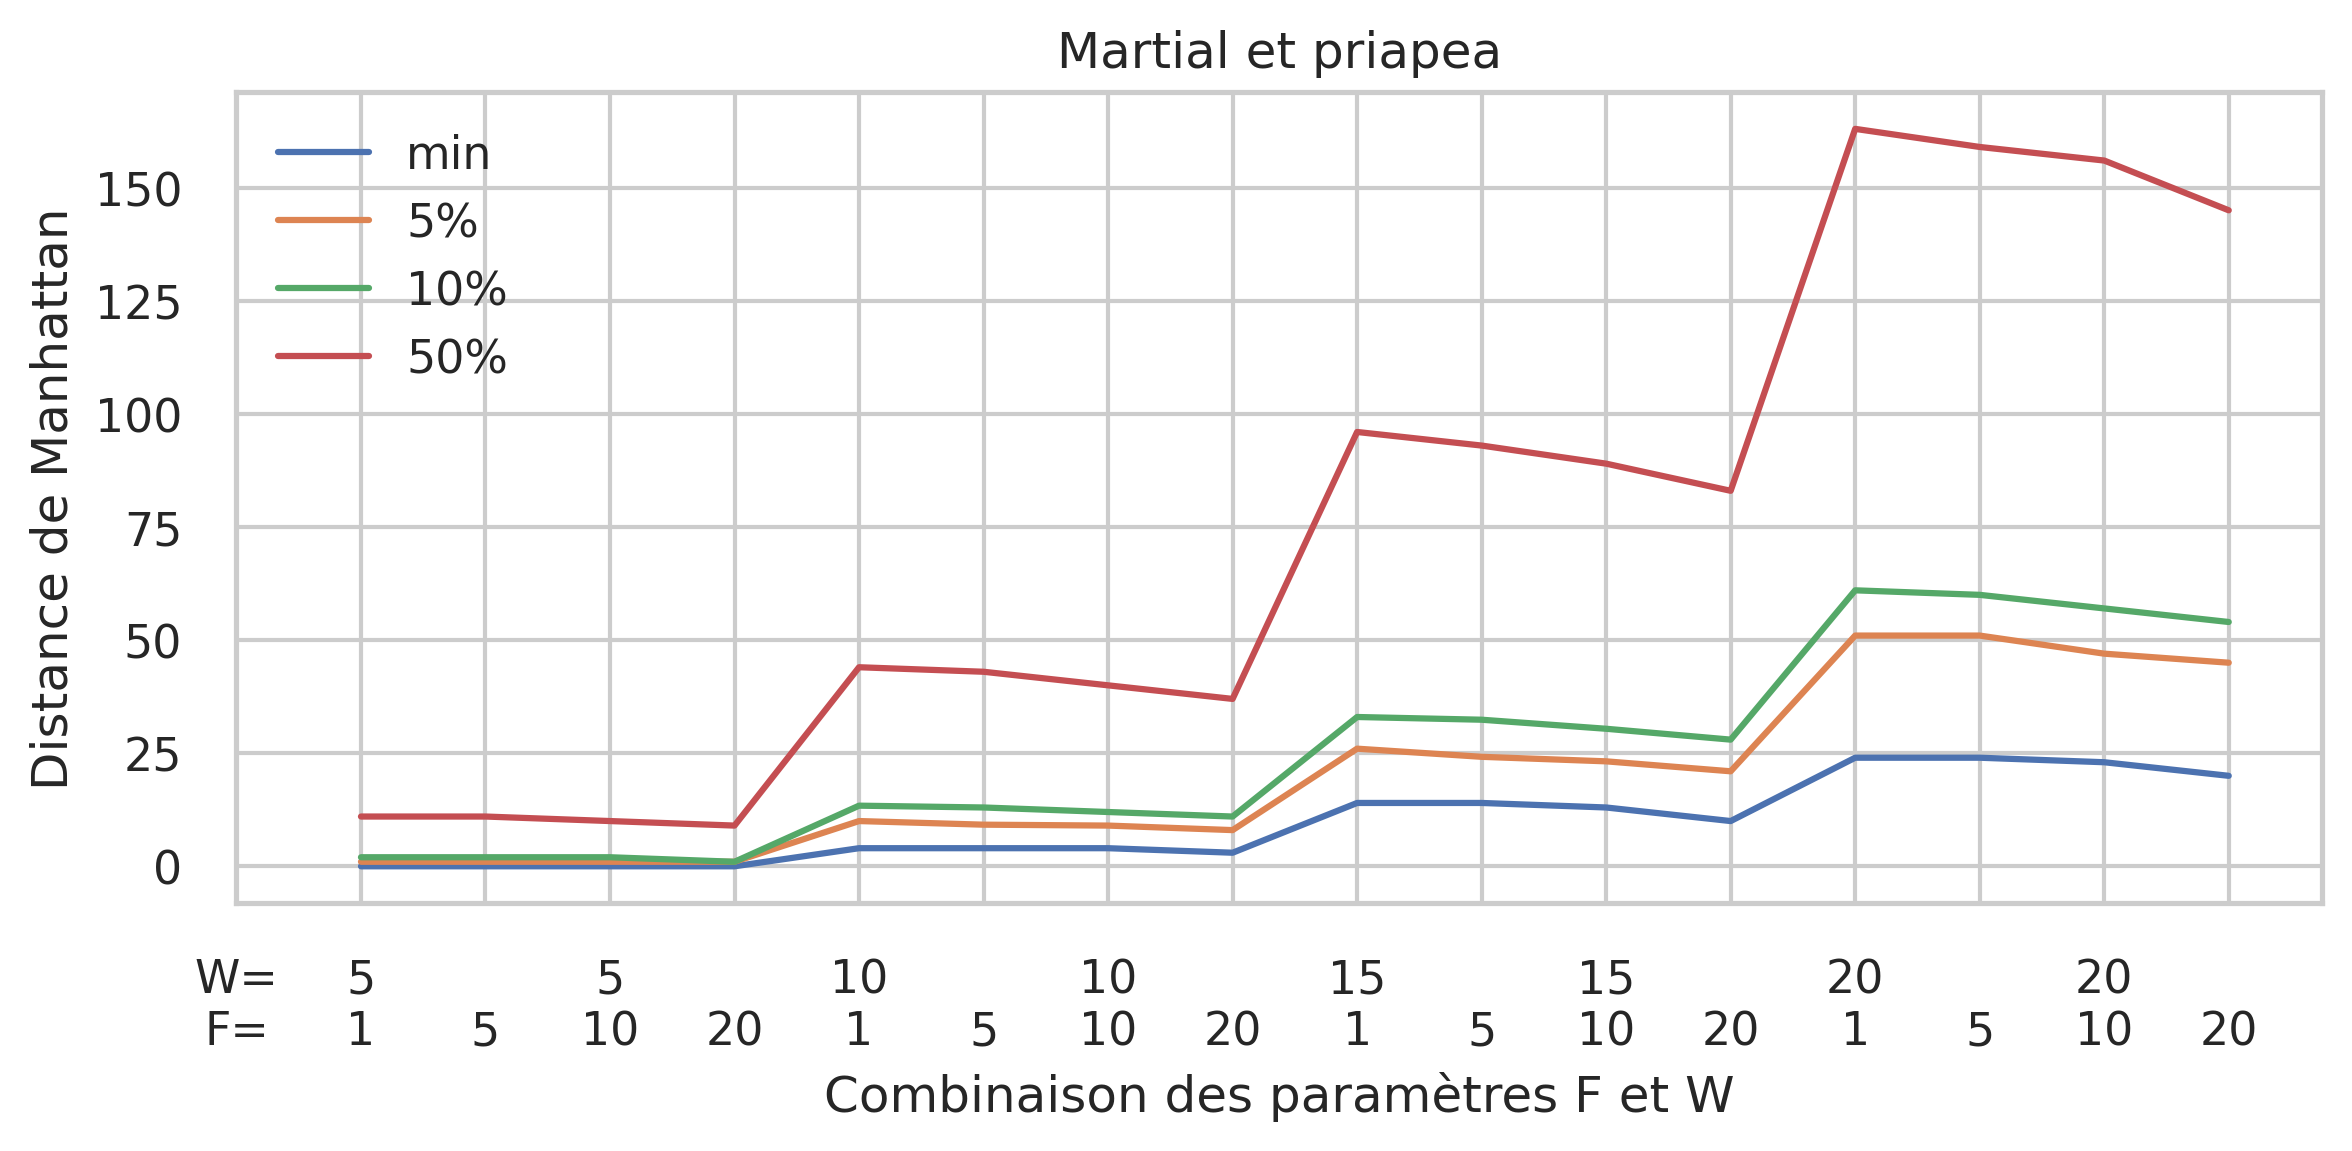

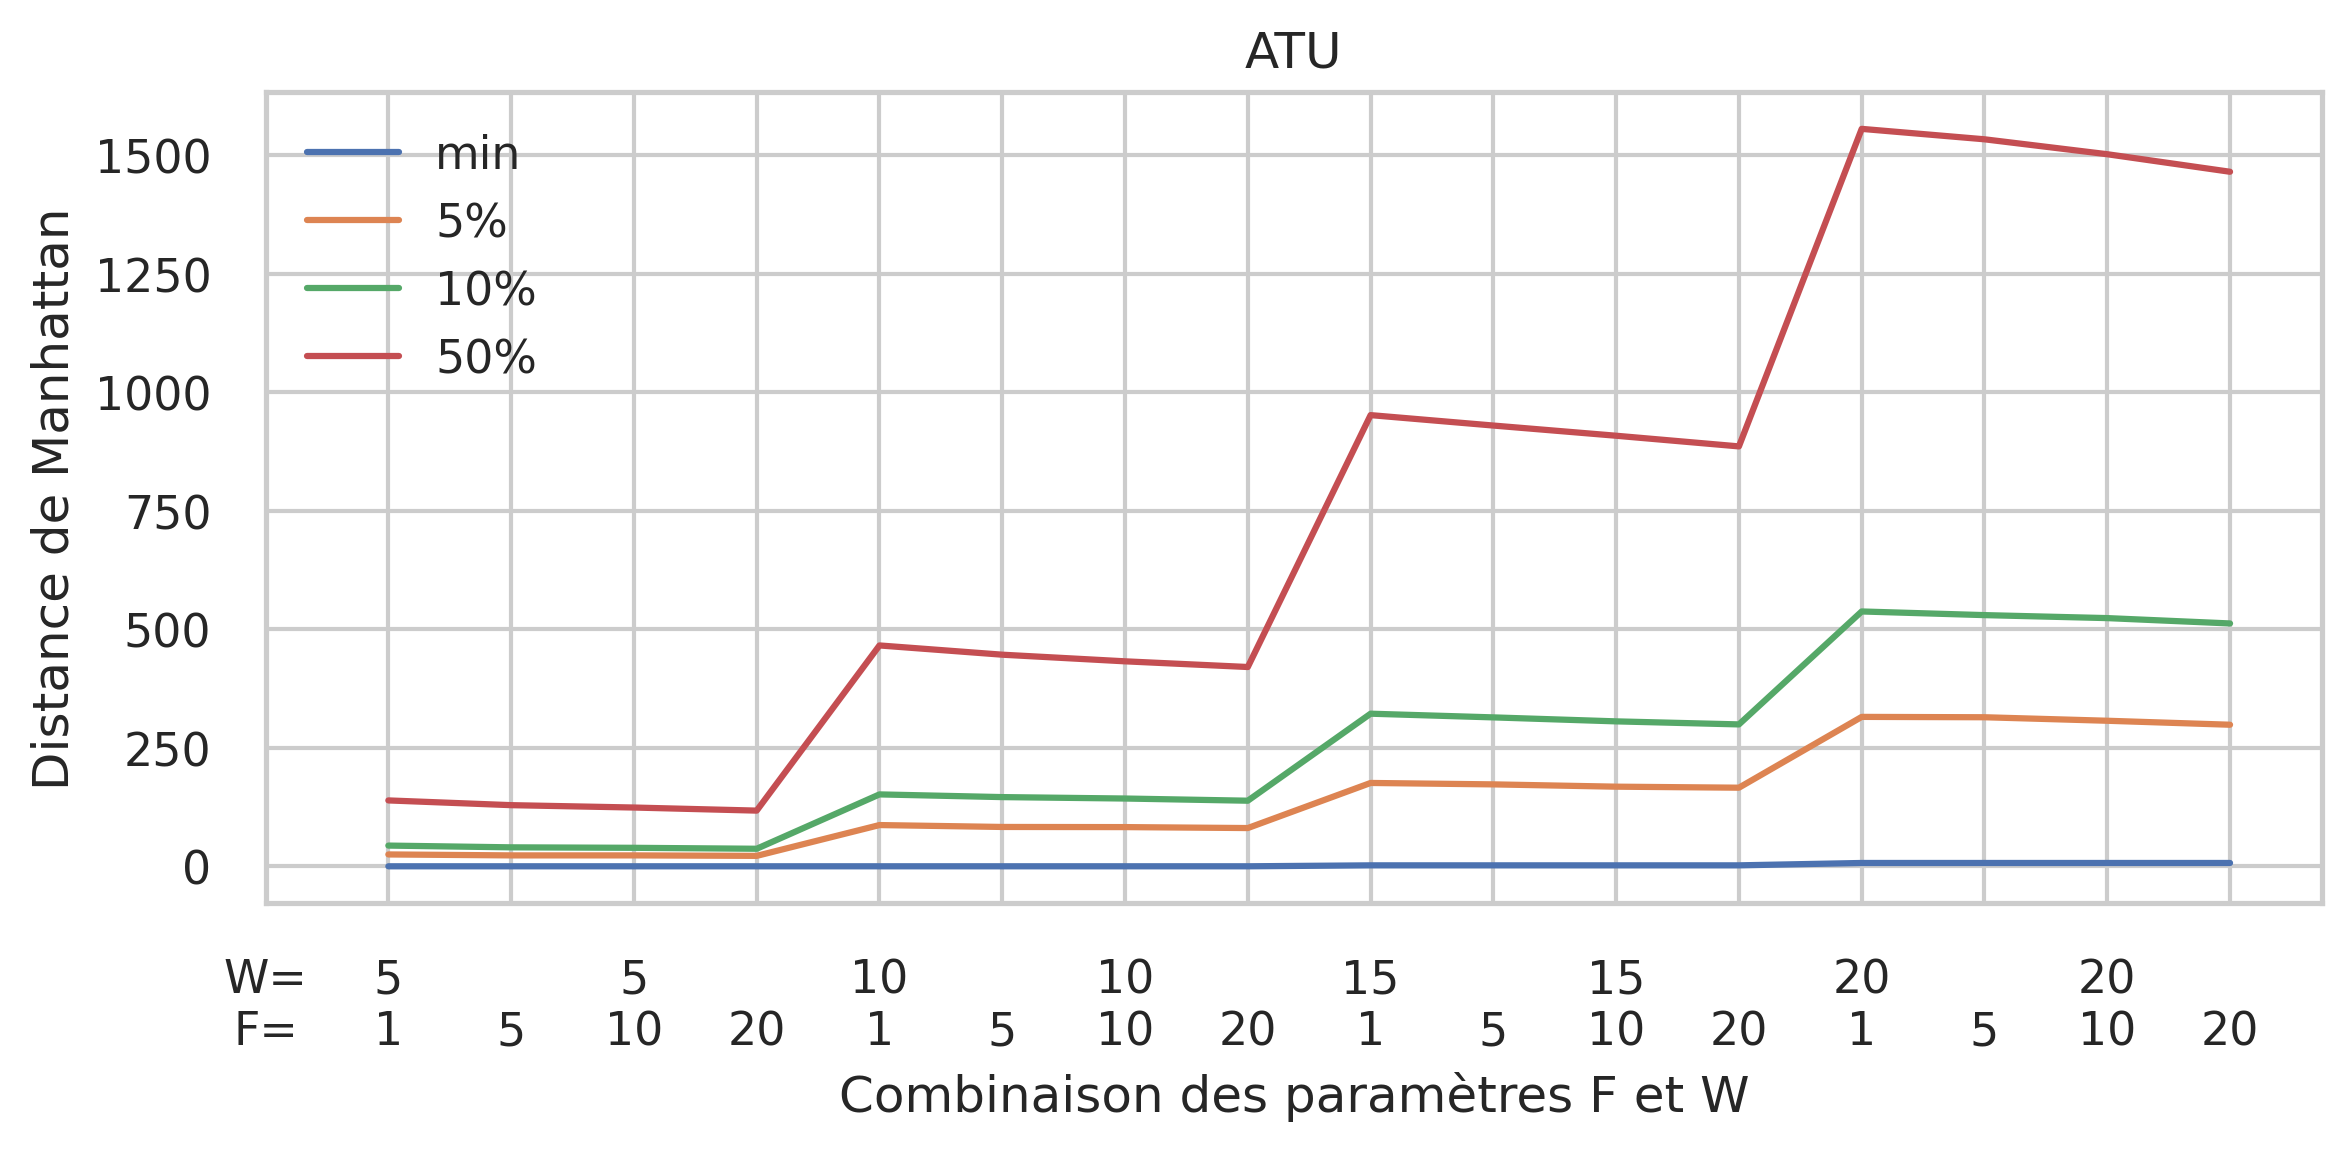

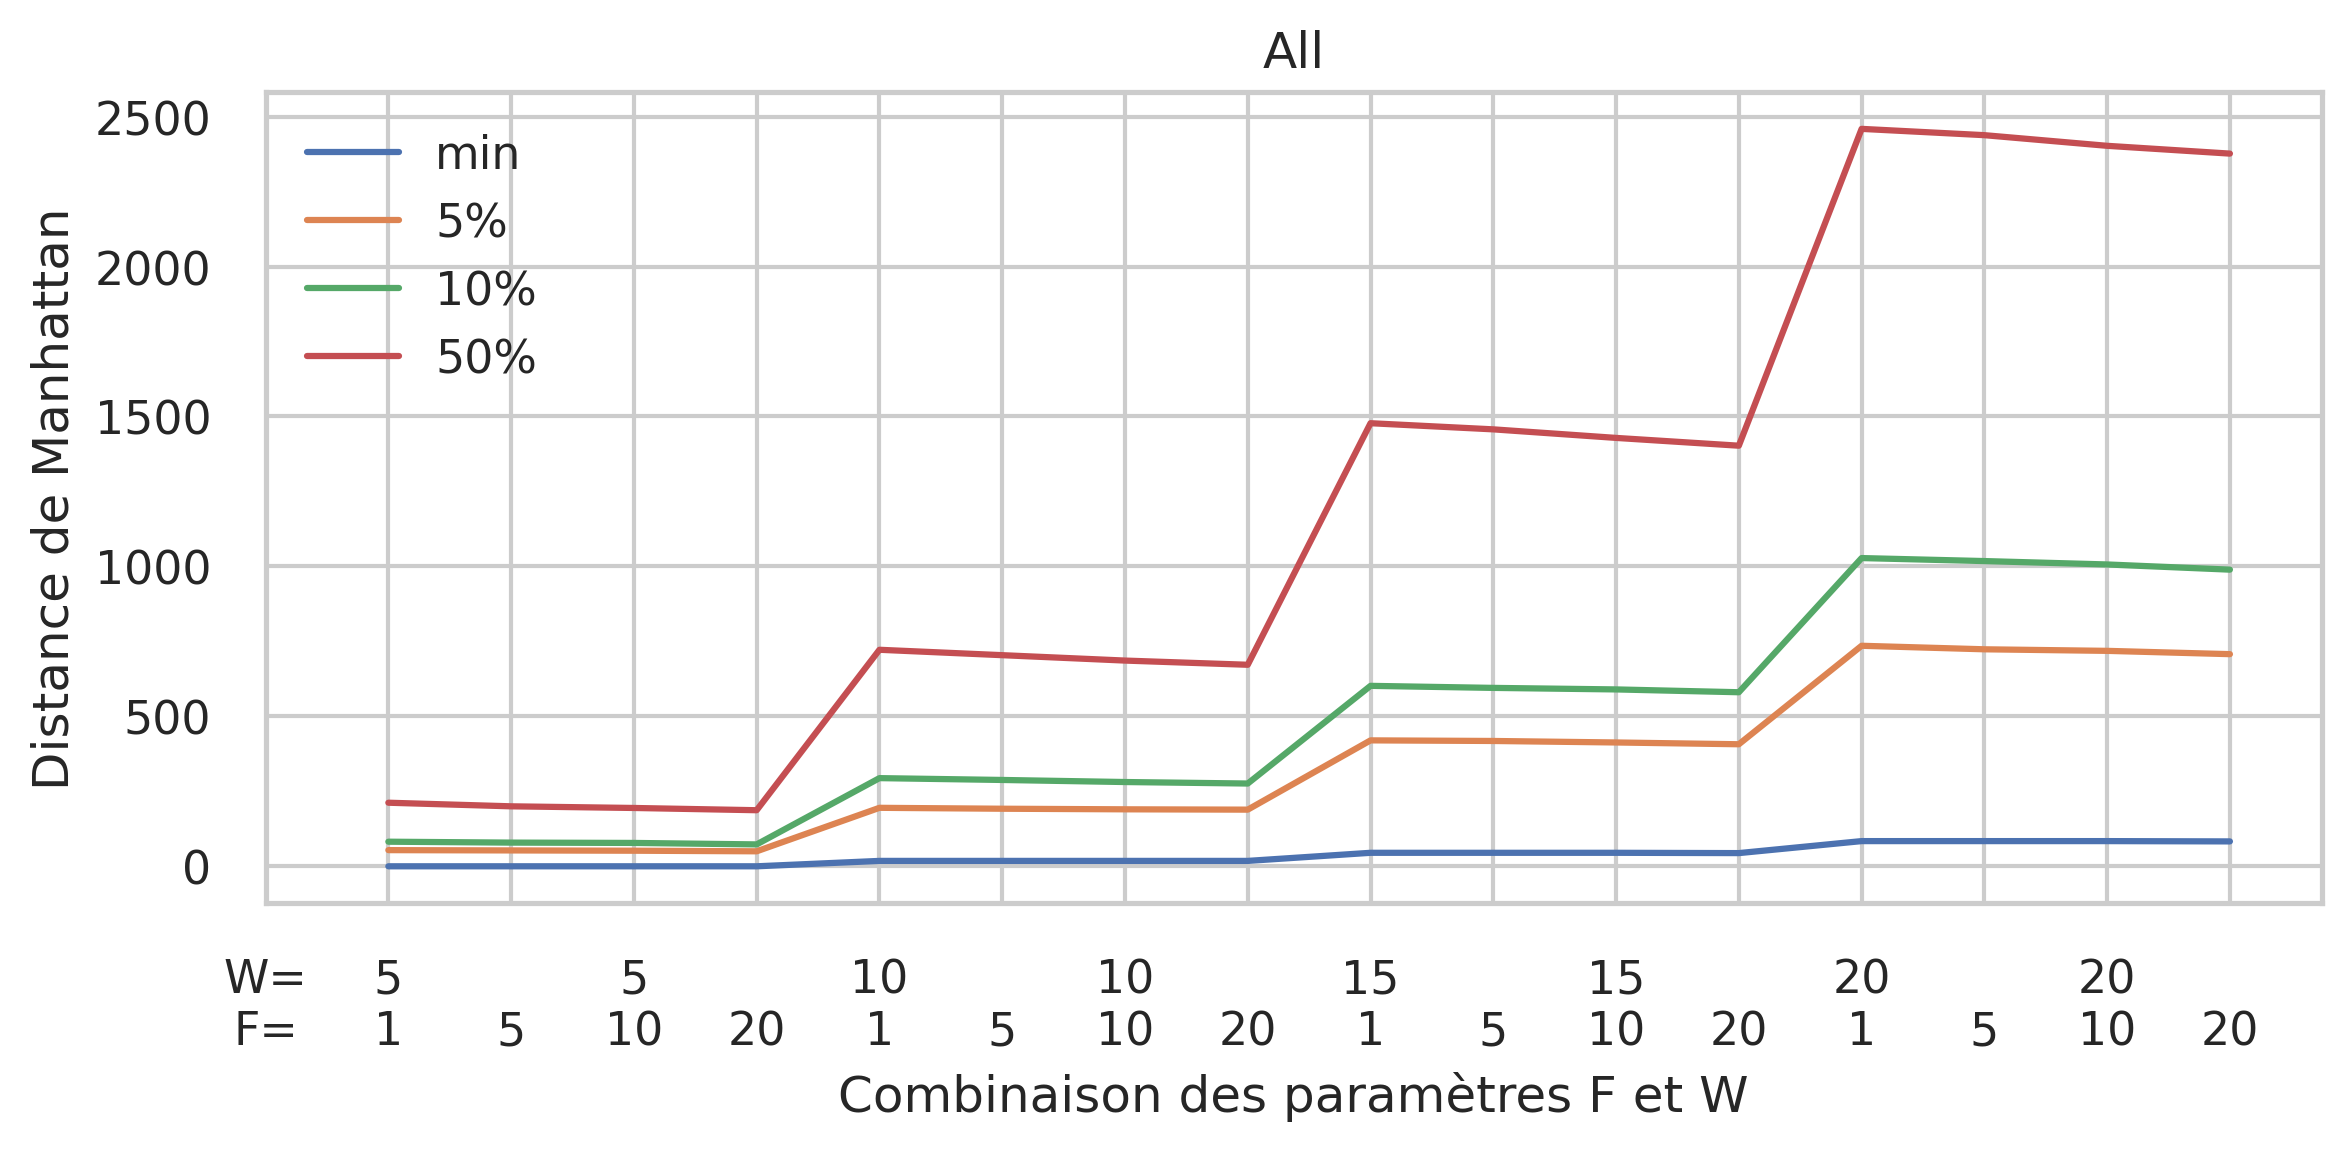

In [114]:
Langs = {
    "fr": {
        "y": "Distance de Manhattan",
        "x": "Combinaison des paramètres F et W"
    },
    "en": {
        "y": "Manhattan distances between\n the same lemma in U(T) and S(T)",
        "x": "Parameters Combination"
    }
}
UseLang = "fr"
sns.set_theme(style="whitegrid")
for corpus, _ in sub_corpora:
    fig, ax = plt.subplots(1, 1, figsize=(8,4), dpi=300)
    subset = DataFrame(Descriptions[Descriptions.name == corpus])
    subset["Parameters Combination"] = list(range(1,17))
    subset.plot(ax=ax, y=["min", "5%", "10%", "50%"], x="Parameters Combination")
    ax.set_xticks(range(0,17))
    labels = ["W=\nF="]
    for w, f in zip(subset.window.to_list(), subset.cooc_floor.to_list()):
        if labels[-1].startswith(f"{w}\n"):
            labels.append(f"\n{f}")
        else:
            labels.append(f"{w}\n{f}")

    ax.set_xticklabels(labels)
    ax.set_ylabel(Langs[UseLang]["y"])
    ax.set_xlabel(Langs[UseLang]["x"])
    ax.set_title(corpus.replace("Small passages", "ATU"))
    plt.tight_layout()
#ax = Descriptions[Descriptions.name == "All"].plot(ax=ax, y=["min", "5%", "10%", "50%"])
#ax.xticks(["x"])